In [1]:
import rlssm
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import csv
from tqdm import tqdm
import math
from tabulate import tabulate
import sys

2021-12-27 19:34:15.115005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-27 19:34:15.115092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## High/Low frequency words

In [2]:
words = []
frq = []
sum_frq = 0
with open("Datasets/meaningful_words_with_frq.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if len(row[0]) > 20: 
            continue
        words.append([row[0], int(row[1])])
        frq.append(int(row[1]))
        sum_frq += int(row[1])


In [3]:
words.sort(key = lambda x: x[1], reverse=True)


In [4]:
hf = words[:int(len(words)/2)]
lf = words[int(len(words)/2):]

In [5]:
hft = []
head = ['HF Word', 'FRQ', 'LF Word', 'FRQ']
for h, f in zip(hf[:10], lf[:10]):
    hft.append([h[0], h[1], f[0], f[1]])

print(tabulate(hft, headers=head, tablefmt='fancy_grid'))


╒═══════════╤═════════════╤═══════════════╤════════╕
│ HF Word   │         FRQ │ LF Word       │    FRQ │
╞═══════════╪═════════════╪═══════════════╪════════╡
│ the       │ 23135851162 │ snips         │ 329153 │
├───────────┼─────────────┼───────────────┼────────┤
│ of        │ 13151942776 │ lockup        │ 329124 │
├───────────┼─────────────┼───────────────┼────────┤
│ and       │ 12997637966 │ tosses        │ 329112 │
├───────────┼─────────────┼───────────────┼────────┤
│ to        │ 12136980858 │ manifesting   │ 329097 │
├───────────┼─────────────┼───────────────┼────────┤
│ a         │  9081174698 │ publics       │ 328930 │
├───────────┼─────────────┼───────────────┼────────┤
│ in        │  8469404971 │ rien          │ 328909 │
├───────────┼─────────────┼───────────────┼────────┤
│ for       │  5933321709 │ resiliency    │ 328858 │
├───────────┼─────────────┼───────────────┼────────┤
│ is        │  4705743816 │ scrip         │ 328826 │
├───────────┼─────────────┼───────────────┼───

# Log Odds

#### Train

In [6]:
cnn_cal = []
lf_count = 0
hf_count = 0
hf_words = list(list(zip(*hf))[0])
lf_words = list(list(zip(*lf))[0])
with open("Datasets/train_dataset_prob.csv", 'r') as file:
    reader = csv.reader(file)
    for k in reader:
        cnn_cal.append(k)

In [7]:
log_odds = []

for e in cnn_cal:
    log_odds.append((math.log((float(e[2])+0.00001)/(float(e[1])+0.00001)))) #log(prob word/prob nonword)
    

In [8]:
print(log_odds[:10])

[-3.8615703592369734, -7.169670307817988, -5.543663717579176, -8.050020410470017, -3.2543118293684605, -1.720629359127239, -5.371011820090665, -4.831069255124716, -5.0781435252875955, -4.599391319210328]


In [9]:
print(cnn_cal[0])

['snuilt', '0.979408', '0.020592', '0']


# Simulation

In [10]:
threshold = 15
ndt = .3
v_inter = 0
v_slope = 1
max_rt = 10

In [11]:
drift_rates = []
for lo in log_odds:
    drift_rates.append(v_inter + v_slope*(lo))

a = [threshold]*len(log_odds)

non_dec_time = [ndt]*len(log_odds)

In [12]:
drift_rates = np.array(drift_rates)
a = np.array(a)
non_dec_time = np.array(non_dec_time)

In [13]:
rt, acc = rlssm.random.random_ddm(drift=drift_rates, threshold=a, ndt=non_dec_time, max_rt=max_rt)

In terms of accuracy <br>
1 : Word <br>
0 : Non-Word

### Statistics

In [14]:
table = []
for e, res_time, accuracy, d in zip(cnn_cal, rt, acc, drift_rates):
    word = e[0]
    nonw_probability = e[1]
    w_probability = e[2]
    word_nonword_type = 'word' if e[3] == '1' else 'nonword'
    if accuracy == 1 and word_nonword_type=='word':
        accur = 'Correct'
    elif accuracy == 0 and word_nonword_type=='nonword':
        accur = "Correct"
    else:
        accur = 'Wrong'

    table.append([word, word_nonword_type, res_time, nonw_probability, w_probability, accur, d])

In [15]:
head = ['Word', 'Type', 'Response Time', 'NW_Prob', 'W_Prob','Accuracy', 'Drift Rate']
print(tabulate(table, headers=head, tablefmt='fancy_grid'))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
gp_accuracy = [0, 0, 0]
gp_rt = [0, 0, 0]

correct_gp_rt = [0, 0, 0]
wrong_gp_rt = [0, 0, 0]
num_words = [0, 0, 0]
hf_words = list(list(zip(*hf))[0])
lf_words = list(list(zip(*lf))[0])

for t in table:
    
    acc_res = 0
    if t[5] == "Correct":
        acc_res = 1
    res_t = t[2]
    if math.isnan(t[2]):
        res_t = max_rt
#         continue
#     if res_t < 0.3 or res_t > 5:
#         continue
    if t[1] == 'nonword':
        gp_accuracy[0] += acc_res
        gp_rt[0] += res_t
        num_words[0] += 1
        if acc_res == 1:
            correct_gp_rt[0] += res_t
        else:
            wrong_gp_rt[0] += res_t
    elif t[0] in hf_words:
        
        gp_accuracy[1] += acc_res
        gp_rt[1] += res_t
        num_words[1] += 1
        if acc_res == 1:
            correct_gp_rt[1] += res_t
        else:
            wrong_gp_rt[1] += res_t
    elif t[0] in lf_words:
        gp_accuracy[2] += acc_res
        gp_rt[2] += res_t
        num_words[2] += 1
        if acc_res == 1:
            correct_gp_rt[2] += res_t
        else:
            wrong_gp_rt[2] += res_t


correct_gp_rt[0] /= gp_accuracy[0]
correct_gp_rt[1] /= gp_accuracy[1]
correct_gp_rt[2] /= gp_accuracy[2]
            
gp_accuracy[0]/=num_words[0]
gp_accuracy[1]/=num_words[1]
gp_accuracy[2]/=num_words[2]


gp_rt[0]/=num_words[0]
gp_rt[1]/=num_words[1]
gp_rt[2]/=num_words[2]



print(f"Accuracy=>\n nonword:  {gp_accuracy[0]}\n high frq word:  {gp_accuracy[1]}\n low frq word:  {gp_accuracy[2]}")       
print(f"Response Time=>\n nonword:  {gp_rt[0]}\n high frq word:  {gp_rt[1]}\n low frq word:  {gp_rt[2]}")       
print(f"Correct Response Time=>\n nonword:  {correct_gp_rt[0]}\n high frq word:  {correct_gp_rt[1]}\n low frq word:  {correct_gp_rt[2]}")       

Accuracy=>
 nonword:  0.9434
 high frq word:  0.8874700718276137
 low frq word:  0.9170008019246191
Response Time=>
 nonword:  2.927564000000002
 high frq word:  2.6697150837988795
 low frq word:  2.1758027265437043
Correct Response Time=>
 nonword:  2.5296459614161577
 high frq word:  1.9253979316546774
 low frq word:  1.6129195452557943


In [ ]:
print(len())

In [20]:
results = []
all_words_in_rt_acc = []
for e, res_time, accuracy, d in zip(cnn_cal, rt, acc, drift_rates):
    if e[0] in all_words_in_rt_acc:
        continue
    if math.isnan(res_time):
        res_time = max_rt
    all_words_in_rt_acc.append(e[0])
    word = e[0]
    nonw_probability = e[1]
    w_probability = e[2]
    word_nonword_type = 'word' if e[3] == '1' else 'nonword'
    
    results.append([word, word_nonword_type, res_time, nonw_probability, w_probability, accuracy, d])
with open("Datasets/train_dataset_rt_acc.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    for k in tqdm(results):
        writer.writerow(k)

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 434904.29it/s]


### Digrams

In [840]:
import seaborn as sns
import matplotlib.pyplot as plt


In [841]:
data = []
acc = []
hf_acc = []
lf_acc = []
nw_acc = []
all_rt = []
hf_rt = []
lf_rt = []
nw_rt = []
prt = []
nrt = []
with open("Datasets/train_dataset_rt_acc.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if float(row[2])<0.3 or float(row[2])>5:
            continue
        
        acc.append(float(row[5]))
        all_rt.append(float(row[2]))
        
        if row[0] in hf_words:
            hf_rt.append(float(row[2]))
            hf_acc.append(float(row[5]))
        elif row[0] in lf_words:
            lf_rt.append(float(row[2]))
            lf_acc.append(float(row[5]))
        else:
            nw_rt.append(float(row[2]))
            nw_acc.append(float(row[5]))
            

### Response Time

/home/mahvash/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Word and Non-Words')

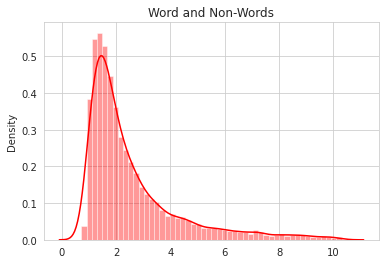

In [842]:
sns.set_style('whitegrid')
sns.distplot(rt, kde = True, color ='red')
plt.title("Word and Non-Words")

/home/mahvash/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


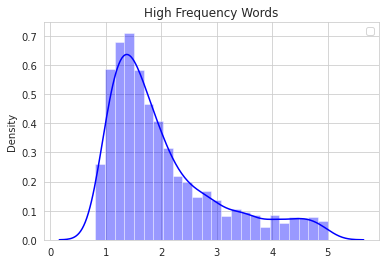

In [843]:
sns.set_style('whitegrid')
sns.distplot(hf_rt, kde = True, color ='blue')
plt.title("High Frequency Words")
plt.legend()

/home/mahvash/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Low Frequency Words')

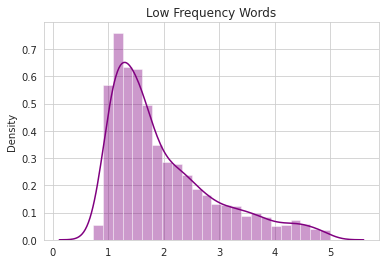

In [844]:
sns.set_style('whitegrid')
sns.distplot(lf_rt, kde = True, color ='purple')
plt.title("Low Frequency Words")

/home/mahvash/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'NonWords')

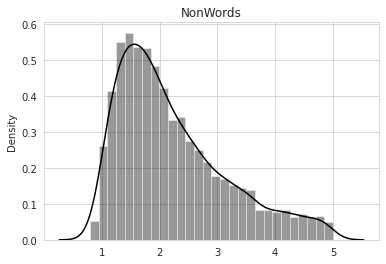

In [845]:
sns.set_style('whitegrid')
sns.distplot(nw_rt, kde = True, color ='black')
plt.title("NonWords")

### Box Digram

Text(0, 0.5, 'Response Time')

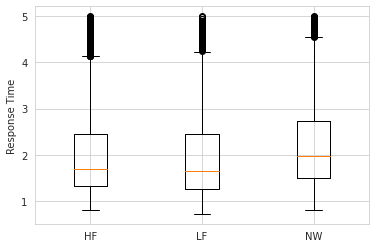

In [846]:
my_dict = {'HF': hf_rt, 'LF': lf_rt, 'NW': nw_rt}
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.ylabel("Response Time")


### Box Plot

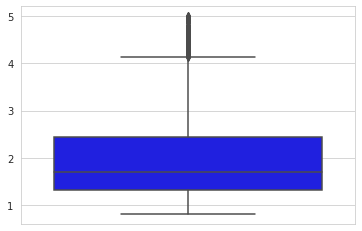

In [847]:
all_data = [hf_rt, lf_rt, nw_rt]
ax = sns.boxplot(y=hf_rt, color ='blue')


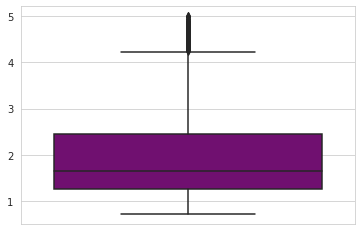

In [848]:
ax = sns.boxplot(y=lf_rt, color ='purple')


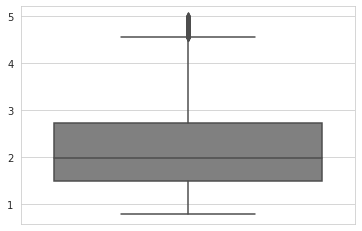

In [849]:
ax = sns.boxplot(y=nw_rt, color ='gray')
